# Coregionalized Regression Model (vector-valued regression)

### updated: 17th June 2015

### by Ricardo Andrade-Pacheco

This tutorial will focus on the use and kernel selection of the $\color{firebrick}{\textbf{coregionalized regression}}$ model in GPy.

## Setup

The first thing to do is to set the plots to be interactive and to import GPy.

In [1]:
%pylab inline
import pylab as pb
pylab.ion()
import GPy

Populating the interactive namespace from numpy and matplotlib


For this example we will generate an artificial dataset.

In [2]:
#This functions generate data corresponding to two outputs
f_output1 = lambda x: 4. * np.cos(x/5.) - .4*x - 35. + np.random.rand(x.size)[:,None] * 2.
f_output2 = lambda x: 6. * np.cos(x/5.) + .2*x + 35. + np.random.rand(x.size)[:,None] * 8.


#{X,Y} training set for each output
X1 = np.random.rand(100)[:,None]; X1=X1*75
X2 = np.random.rand(100)[:,None]; X2=X2*70 + 30
Y1 = f_output1(X1)
Y2 = f_output2(X2)
#{X,Y} test set for each output
Xt1 = np.random.rand(100)[:,None]*100
Xt2 = np.random.rand(100)[:,None]*100
Yt1 = f_output1(Xt1)
Yt2 = f_output2(Xt2)

Our two datasets look like this:

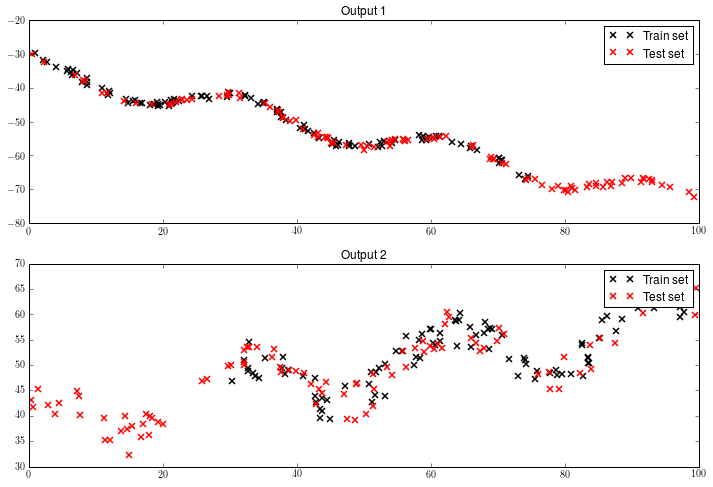

In [3]:
xlim = (0,100); ylim = (0,50)
fig = pb.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1.set_xlim(xlim)
ax1.set_title('Output 1')
ax1.plot(X1[:,:1],Y1,'kx',mew=1.5,label='Train set')
ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5,label='Test set')
ax1.legend()
ax2 = fig.add_subplot(212)
ax2.set_xlim(xlim)
ax2.set_title('Output 2')
ax2.plot(X2[:,:1],Y2,'kx',mew=1.5,label='Train set')
ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5,label='Test set')
ax2.legend()

We will also define a function that will be used later for plotting our results.

In [4]:
def plot_2outputs(m,xlim,ylim):
    fig = pb.figure(figsize=(12,8))
    #Output 1
    ax1 = fig.add_subplot(211)
    ax1.set_xlim(xlim)
    ax1.set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,100),ax=ax1)
    ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5)
    #Output 2
    ax2 = fig.add_subplot(212)
    ax2.set_xlim(xlim)
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(100,200),ax=ax2)
    ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5)

### Covariance kernel

The coregionalized regression model relies on the use of 
$\color{firebrick}{\textbf{multiple output kernels}}$ or $\color{firebrick}{\textbf{vector-valued kernels}}$
[(Álvarez, Rosasco and Lawrence, 2012)](http://www.nowpublishers.com/articles/foundations-and-trends-in-machine-learning/MAL-036;jsessionid=0659F0627887C5F2742261E8D6D1FBF7), of the following form:

$
\begin{align*}
{\bf B}\otimes{\bf K} =
\left(\begin{array}{ccc}
B_{1,1}\times{\bf K}({\bf X}_{1},{\bf X}_{1}) & \ldots & B_{1,D}\times{\bf K}({\bf X}_{1},{\bf X}_{D})\\
\vdots & \ddots & \vdots\\
B_{D,1}\times{\bf K}({\bf X}_{D},{\bf X}_{1}) & \ldots & B_{D,D}\times{\bf K}({\bf X}_{D},{\bf X}_{D})
\end{array}\right)
\end{align*}
$.

In the expression above, ${\bf K}$ is a kernel function, ${\bf B}$ is a regarded as the coregionalization matrix, and ${\bf X}_i$ represents the inputs corresponding to the $i$-th output.

Notice that if $B_{i,j} = 0$ for $i \neq j$, then all the outputs are being considered as independent of each other. 

To ensure that the multiple output kernel is a valid kernel, we need the $\bf K$ and ${\bf B}$ to be to be valid. If $\bf K$ is already a valid kernel, we just need to ensure that ${\bf B}$ is positive definite. The last is achieved by defining ${\bf B} = {\bf W}{\bf W}^\top + {\boldsymbol \kappa}{\bf I}$, for some matrix $\bf W$ and vector ${\boldsymbol \kappa}$.

In GPy, a multiple output kernel is defined in the following way:

In [5]:
import GPy
K=GPy.kern.RBF(1)
B = GPy.kern.Coregionalize(input_dim=1,output_dim=2) 
multkernel = K.prod(B,name='B.K')
print multkernel

  B_K.             |   value  |  constraints  |  priors
  rbf.variance     |     1.0  |      +ve      |        
  rbf.lengthscale  |     1.0  |      +ve      |        
  coregion.W       |  (2, 1)  |               |        
  coregion.kappa   |    (2,)  |      +ve      |        


The components of the kernel can be accessed as follows:

In [6]:
#Components of B
print 'W matrix\n',B.W
print '\nkappa vector\n',B.kappa
print '\nB matrix\n',B.B

W matrix
  index  |  B_K.coregion.W  |  constraints  |  priors
  [0 0]  |      0.67770340  |               |        
  [1 0]  |     -0.00412505  |               |        

kappa vector
  index  |  B_K.coregion.kappa  |  constraints  |  priors
  [0]    |          0.50000000  |      +ve      |        
  [1]    |          0.50000000  |      +ve      |        

B matrix
[[ 0.9592819  -0.00279556]
 [-0.00279556  0.50001702]]


We have built a function called $\color{firebrick}{\textbf{ICM}}$ that deals with the steps of defining two kernels and multiplying them together. 

In [7]:
icm = GPy.util.multioutput.ICM(input_dim=1,num_outputs=2,kernel=GPy.kern.RBF(1))
print icm

  ICM.             |   value  |  constraints  |  priors
  rbf.variance     |     1.0  |      +ve      |        
  rbf.lengthscale  |     1.0  |      +ve      |        
  B.W              |  (2, 1)  |               |        
  B.kappa          |    (2,)  |      +ve      |        


Now we will show how to add different kernels together to model the data in our example.

### Using the GPy's Coregionalized Regression Model

Once we have defined an appropiate kernel for our model, its use is straightforward. In the next example we will use a
$\color{firebrick}{\textbf{Matern-3/2 kernel}}$ as $\bf K$.


Name : gp
Objective : 376.744145175
Number of Parameters : 8
Number of Optimization Parameters : 7
Updates : True
Parameters:
  gp.                                    |           value  |  constraints  |  priors
  ICM.Mat32.variance                     |             1.0  |   fixed +ve   |        
  ICM.Mat32.lengthscale                  |   178.415052332  |      +ve      |        
  ICM.B.W                                |          (2, 1)  |               |        
  ICM.B.kappa                            |            (2,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |  0.352294081182  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |   5.06765701728  |      +ve      |        


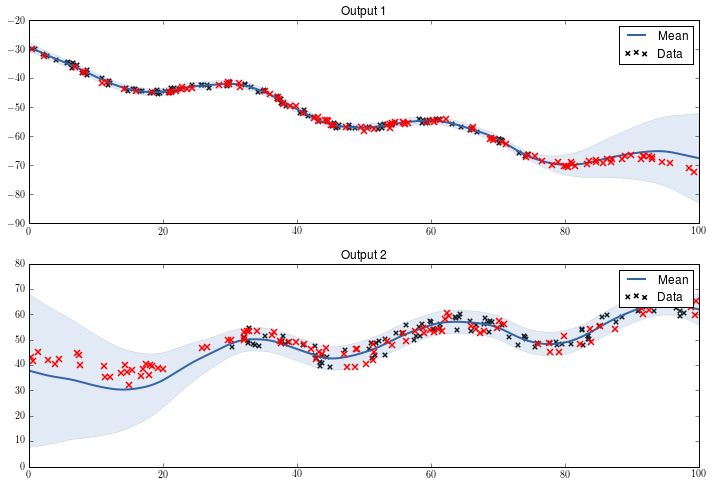

In [8]:
K = GPy.kern.Matern32(1)
icm = GPy.util.multioutput.ICM(input_dim=1,num_outputs=2,kernel=K)

m = GPy.models.GPCoregionalizedRegression([X1,X2],[Y1,Y2],kernel=icm)
m['.*Mat32.var'].constrain_fixed(1.) #For this kernel, B.kappa encodes the variance now.
m.optimize()
print m
plot_2outputs(m,xlim=(0,100),ylim=(-20,60))

Notice that the there are two parameters for the $\color{firebrick}{\textbf{noise variance}}$. Each one corresponds to the noise of each output.

But what is the advantage of this model? Well, the fit of a non-coregionalized model (i.e., two independent models) would look like this:

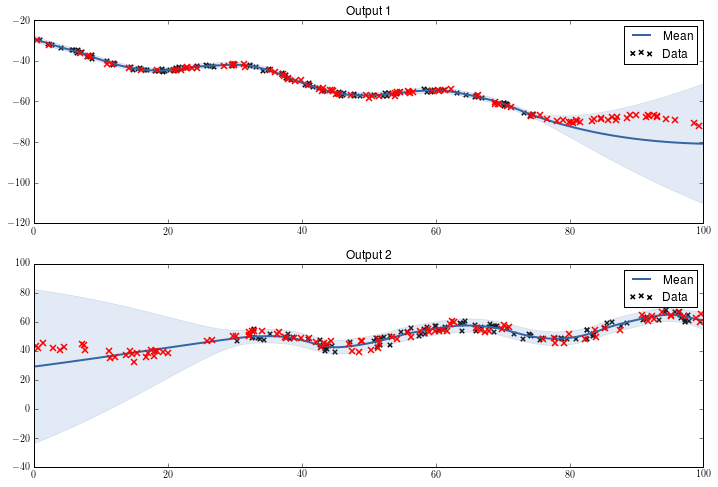

In [9]:
K = GPy.kern.Matern32(1)

m1 = GPy.models.GPRegression(X1,Y1,kernel=K.copy())
m1.optimize()
m2 = GPy.models.GPRegression(X2,Y2,kernel=K.copy())
m2.optimize()
fig = pb.figure(figsize=(12,8))
#Output 1
ax1 = fig.add_subplot(211)
m1.plot(plot_limits=xlim,ax=ax1)
ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5)
ax1.set_title('Output 1')
#Output 2
ax2 = fig.add_subplot(212)
m2.plot(plot_limits=xlim,ax=ax2)
ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5)
ax2.set_title('Output 2')

The coregionalized model shares information across outputs, but the independent models cannot do that. In the regions where there is no training data specific to an output the independent models tend to return to the prior assumptions.
In this case, where both outputs have associated patterns, the fit is better with the coregionalized model.

$\color{firebrick}{\textbf{Can we improve the fit in the coregionalization?}}$
Yes, we will have a look at that in the next section.

### Kernel Selection

The data from both outputs is not centered on zero. A way of dealing with outputs of different means or magnitudes is using a 
$\color{firebrick}{\textbf{bias kernel}}$.

This kernel is just changing the mean (constant) of the Gaussian Process being fitted. There is no need to assume any sort of correlation between both means, so we can define ${\bf W} = {\bf 0}$.

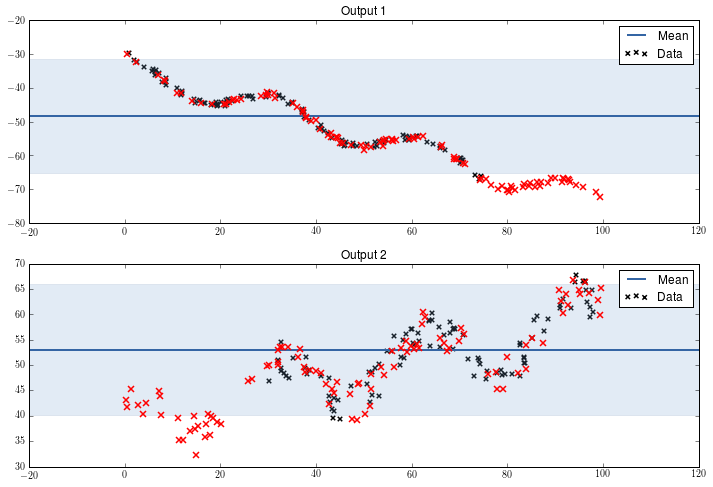

In [10]:
kernel = GPy.util.multioutput.ICM(input_dim=1,num_outputs=2,kernel=GPy.kern.Bias(input_dim=1))
m = GPy.models.GPCoregionalizedRegression(X_list=[X1,X2],Y_list=[Y1,Y2],kernel=kernel)
m['.*bias.var'].constrain_fixed(1) #B.kappa now encodes the variance.
m['.*W'].constrain_fixed(0)
m.optimize()
plot_2outputs(m,xlim=(-20,120),ylim=(0,60))

At the moment, our model is only able to explain the mean of the data. However we can notice that there is a deacreasing trend in the first output and and increasent trend in the second one. In this case we can model such a trend with a 
$\color{firebrick}{\textbf{linear kernel}}$.

Since the linear kernel only fits a line with constant slope along the output space, there is no need to assume any correlation between outputs.

We could define our new multiple output kernel as follows:

${\bf K}_{ICM} = {\bf B} \otimes ( {\bf K}_{Bias} + {\bf K}_{Linear} )$.

However, we can also define a more general kernel of the following form:

${\bf K}_{LCM} = {\bf B}_1 \otimes {\bf K}_{Bias} + {\bf B}_2 \otimes {\bf K}_{Linear}$.

GPy has also a function which saves some steps in the definition of 
$\color{firebrick}{\textbf{LCM}}$ kernels.

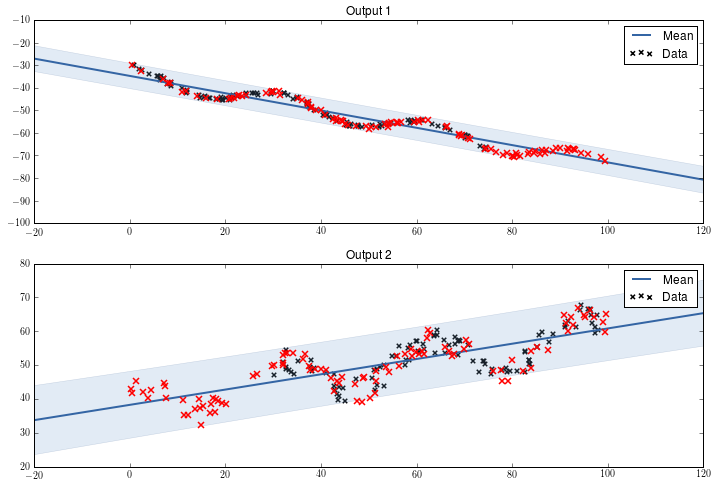

In [11]:
K1 = GPy.kern.Bias(1)
K2 = GPy.kern.Linear(1)
lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=2,kernels_list=[K1,K2])

m = GPy.models.GPCoregionalizedRegression([X1,X2],[Y1,Y2],kernel=lcm)
m['.*bias.var'].constrain_fixed(1.)
m['.*W'].constrain_fixed(0)
m['.*linear.var'].constrain_fixed(1.)
m.optimize()
plot_2outputs(m,xlim=(-20,120),ylim=(0,60))

Now we will model the variation along the trend defined by the linear component. We will do this with a Matern-3/2 kernel.

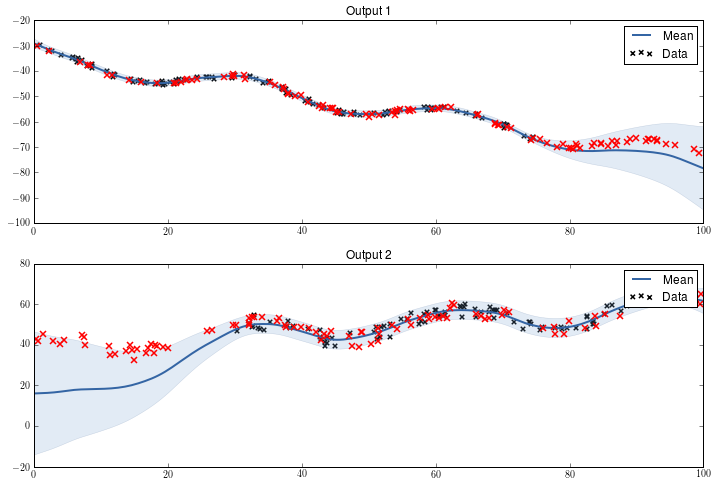

In [12]:
K1 = GPy.kern.Bias(1)
K2 = GPy.kern.Linear(1)
K3 = GPy.kern.Matern32(1)
lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=2,kernels_list=[K1,K2,K3])

m = GPy.models.GPCoregionalizedRegression([X1,X2],[Y1,Y2],kernel=lcm)
m['.*ICM.*var'].unconstrain()
m['.*ICM0.*var'].constrain_fixed(1.)
m['.*ICM0.*W'].constrain_fixed(0)
m['.*ICM1.*var'].constrain_fixed(1.)
m['.*ICM1.*W'].constrain_fixed(0)
m.optimize()
plot_2outputs(m,xlim=(0,100),ylim=(-20,60))

### Prediction at new input values

Behind the scenes, this model is using an extended input space with an additional dimension that points at the output each data point belongs to. To make use of the prediction function of GPy, this model needs the input array to have the extended format.

For example if we want to make predictions in the region 100 to 100 for the second output, we need to define the new inputs as follows:

In [13]:
newX = np.arange(100,110)[:,None]
newX = np.hstack([newX,np.ones_like(newX)])
print newX

[[100   1]
 [101   1]
 [102   1]
 [103   1]
 [104   1]
 [105   1]
 [106   1]
 [107   1]
 [108   1]
 [109   1]]


$\color{firebrick}{\textbf{Note:}}$ remember that Python starts counting from zero, so input 1 is actually the second input.

We also need to pass another output to the predict function. This is an array that tells which $\color{firebrick}{\textbf{noise model}}$ is associated to each point to be predicted. This is a dictionary constructed as follows:

In [14]:
noise_dict = {'output_index':newX[:,1:].astype(int)}

The astype(int) function is to ensure that the values of the dictionary are integers, otherwise the Python complains when using them as indices. Then prediction is command can then be called this way:

In [15]:
m.predict(newX,Y_metadata=noise_dict)

(array([[ 61.6493168 ],
        [ 60.97078391],
        [ 60.29634431],
        [ 59.62608188],
        [ 58.96007595],
        [ 58.29840145],
        [ 57.64112904],
        [ 56.98832524],
        [ 56.34005258],
        [ 55.6963697 ]]), array([[  10.03066081],
        [  13.9122405 ],
        [  19.37464407],
        [  26.60289973],
        [  35.75497252],
        [  46.96392513],
        [  60.33994173],
        [  75.97221989],
        [  93.93074111],
        [ 114.26792495]]))

$\color{firebrick}{\textbf{Why we need the output_index if we already extend the input space?}}$

In the case of the coregionalized model, each output is automatically assigned a specific Gaussian noise parameter. However, GPy is flexible enough to do more crazy stuff. Think about using an heteroscedastic noise model for each output... Not straightforward, at the moment, but the pieces are in place to handle it.

We can even use different models, not only Gaussian noise. For example, Bernoulli noise or Poisson noise... but that is part of a future notebook. 